In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
np.random.seed(7)

In [4]:
# normalize the dataset
hourly_df=pd.read_pickle("C:\\Users\\Chike\\Documents\\Projects\\weather_repo\\data\\raw\\1.0_Montreal_1990-01-01_2021-04-23.pkl")
hourly_df['Temperature_Fahrenheit']=pd.to_numeric(hourly_df['Temperature_Fahrenheit'])
hourly_df['Dew_Point_Fahrenheit']=pd.to_numeric(hourly_df['Dew_Point_Fahrenheit'])
hourly_df['Wind_Speed_MPH']=pd.to_numeric(hourly_df['Wind_Speed_MPH'])
hourly_df['Wind_Gust_MPH']=pd.to_numeric(hourly_df['Wind_Gust_MPH'])
hourly_df['Date']=pd.to_datetime(hourly_df['Date'],infer_datetime_format=True)
daily_df=(hourly_df
          .groupby(['Date'],as_index=True)
          .agg({'Temperature_Fahrenheit':['min','max','mean']
              ,'Dew_Point_Fahrenheit':['min','max','mean']
              ,'Wind_Speed_MPH':['min','max','mean']
              ,'Wind_Gust_MPH':['min','max','mean']}))
daily_df.columns = daily_df.columns.map('{0[0]}_{0[1]}'.format) 
# daily_df['Date']=daily_df['Date_']
# daily_df.drop('Date_',axis=1)
daily_df=daily_df.reset_index()
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(daily_df[['Temperature_Fahrenheit_min']])

In [5]:
# train_size = int(len(daily_df) * 0.8)
# test_size = len(daily_df) - train_size
# train, test = daily_df.iloc[0:train_size], daily_df.iloc[train_size:len(daily_df)]
# print(len(train), len(test))

In [6]:
# def create_dataset(X, y, time_steps=1):
#     Xs, ys = [], []
#     for i in range(len(X) - time_steps):
#         v = X.iloc[i:(i + time_steps)].values
#         Xs.append(v)
#         ys.append(y.iloc[i + time_steps])
#     return np.array(Xs), np.array(ys)

In [7]:
# time_steps = 10

# # reshape to [samples, time_steps, n_features]

# X_train, y_train = create_dataset(train['Date'], train.Temperature_Fahrenheit_min, time_steps)
# X_test, y_test = create_dataset(test['Date'], test.Temperature_Fahrenheit_min, time_steps)

# print(X_train.shape, y_train.shape)

In [8]:
# model = keras.Sequential()
# model.add(keras.layers.LSTM(
#   units=128,
#   input_shape=(X_train.shape[0], X_train.shape[1])
# ))
# model.add(keras.layers.Dense(units=1))
# model.compile(
#   loss='mean_squared_error',
#   optimizer=keras.optimizers.Adam(0.001)
# )

In [9]:

# history = model.fit(
#     X_train, y_train,
#     epochs=30,
#     batch_size=16,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False
# )

In [10]:
# Convert the data values to numpy for better and faster processing 
time_index = np.array(daily_df['Date']) 
data = np.array(daily_df[['Temperature_Fahrenheit_min']])   
# Certain Hyper-parameters to tune 
SPLIT_RATIO = 0.8 
WINDOW_SIZE = 60 
BATCH_SIZE = 32 
SHUFFLE_BUFFER = 1000  
# Dividing into train-test split 
split_index = int(SPLIT_RATIO * data.shape[0])   
# Train-Test Split 
train_data = data[:split_index] 
train_time = time_index[:split_index]  
test_data = data[split_index:] 
test_time = time_index[split_index:]

In [11]:
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
    """Utility function for time series data generation in batches"""
    ts_data = tf.data.Dataset.from_tensor_slices(data)
    ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
    ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
    ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    ts_data = ts_data.batch(batch_size).prefetch(1)
    return ts_data
# Expanding data into tensors
tensor_train_data = tf.expand_dims(train_data, axis=-1)
tensor_test_data = tf.expand_dims(test_data, axis=-1)

tensor_train_dataset = ts_data_generator(tensor_train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
tensor_test_dataset = ts_data_generator(tensor_test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [12]:
# DHL Fusion model of 1D CNN and LSTM 
model = tf.keras.models.Sequential([tf.keras.layers.Conv1D(filters=32, 
                                                           kernel_size=5,
                                                           strides=1, 
                                                           padding="causal",
                                                           activation="relu",                       
                                                           input_shape=[None, 1]),
                                    tf.keras.layers.LSTM(64, return_sequences=True),   
                                    tf.keras.layers.LSTM(64, return_sequences=True),   
                                    tf.keras.layers.Dense(30, activation="relu"),   
                                    tf.keras.layers.Dense(10, activation="relu"),   
                                    tf.keras.layers.Dense(1)])

In [13]:
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(tensor_train_dataset, epochs=30, validation_data=tensor_test_dataset)

Epoch 1/30
284/284 [==============================] - 19s 57ms/step - loss: 34.2135 - mae: 34.6575 - val_loss: 36.4826 - val_mae: 36.9816
Epoch 2/30
284/284 [==============================] - 16s 56ms/step - loss: 31.4890 - mae: 31.9859 - val_loss: 17.8351 - val_mae: 18.3247
Epoch 3/30
284/284 [==============================] - 15s 52ms/step - loss: 17.0475 - mae: 17.5424 - val_loss: 11.6514 - val_mae: 12.1439
Epoch 4/30
284/284 [==============================] - 15s 52ms/step - loss: 13.0211 - mae: 13.5137 - val_loss: 11.1227 - val_mae: 11.6132
Epoch 5/30
284/284 [==============================] - 15s 52ms/step - loss: 12.4384 - mae: 12.9302 - val_loss: 10.6799 - val_mae: 11.1703
Epoch 6/30
284/284 [==============================] - 15s 51ms/step - loss: 12.1794 - mae: 12.6707 - val_loss: 10.8933 - val_mae: 11.3839
Epoch 7/30
284/284 [==============================] - 15s 52ms/step - loss: 12.1671 - mae: 12.6585 - val_loss: 10.2746 - val_mae: 10.7634
Epoch 8/30
284/284 [==============

In [15]:
def model_forecast(model, data, window_size):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast
rnn_forecast = model_forecast(model, data[..., np.newaxis], WINDOW_SIZE) 
rnn_forecast = rnn_forecast[split_index - WINDOW_SIZE:-1, -1, 0]
# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, rnn_forecast).numpy()
print(error)

[33.879307 27.366655 38.8793   ... 15.441272 17.863625 18.284632]


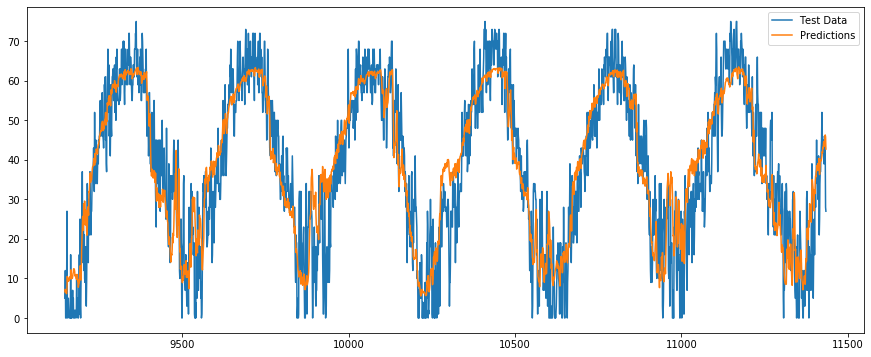

No handles with labels found to put in legend.


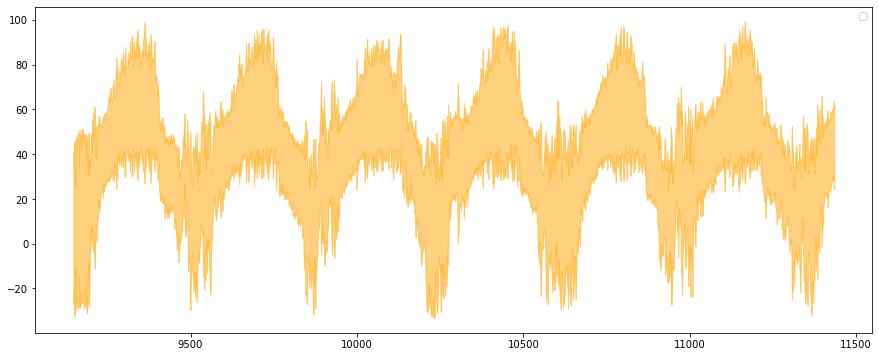

In [17]:
plt.figure(figsize=(15, 6))  
plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data') 
plt.plot(list(range(split_index,len(data))), rnn_forecast, label = 'Predictions') 
plt.legend() 
plt.show()  
plt.figure(figsize=(15, 6)) 
# Plotting with Confidence Intervals plt.plot(list(range(split_index,len(data))), rnn_forecast, label = 'Predictions', color = 'k', linestyle = '--')
plt.fill_between(range(split_index,len(data)), rnn_forecast - error, rnn_forecast + error, alpha = 0.5, color = 'orange') 
plt.legend() 
plt.show()